In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA,SparsePCA,IncrementalPCA,TruncatedSVD,FastICA,MiniBatchSparsePCA,FactorAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import random
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/論文程式/Electrical Grid.csv")

data_x = data.drop(['stab','stabf'],axis=1)
data_y = data['stab']

scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(data_x)
scaled_x = pd.DataFrame(scaled_x, columns=data_x.columns)

def get_random_subset(iterable,k):
    subsets = []
    iteration = 0
    np.random.shuffle(iterable)
    subset = 0
    limit = len(iterable)/k
    while iteration < limit:
        if k <= len(iterable):
            subset = k
        else:
            subset = len(iterable)
        subsets.append(iterable[-subset:])
        del iterable[-subset:]
        iteration+=1
    return subsets

Mounted at /content/drive


In [1]:
def Strength_Rotation_Forest(X , Y, test_x, max_depth, size, n_trees, k):
    strength_set = []
    Prediction_set = []
    r_matrices , models = [],[]
    for tree in range(n_trees):
        feature_index = list(range(X.shape[1]))
        k_subset = get_random_subset(feature_index,k) #每個子集有k個特徵，每個子集特徵不重複 #將訓練集中的屬性拆分為大小相等的 K 個非重疊子集。
        rotation_matrix = np.zeros((X.shape[1],X.shape[1]),dtype=float) #591*591大小的矩陣
        X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size = size)

        for each_subset in k_subset:
            pca = PCA()
            x_train,_,_,_ = train_test_split(X_train, y_train, train_size = 0.7)
            X_subset = x_train.iloc[:,each_subset]
            pca.fit(X_subset)
            for i in range(0,len(pca.components_)):
                for j in range(0,len(pca.components_)):
                    rotation_matrix[ each_subset[i],each_subset[j] ] = pca.components_[i,j]

        x_transformed = X_train.dot(rotation_matrix)
        model = DecisionTreeRegressor(max_depth = max_depth).fit(x_transformed,y_train)

        x_valid_transformed = X_valid.dot(rotation_matrix)
        valid_prediction = model.predict(x_valid_transformed)

        models.append(model) #存放每個樹的模型
        r_matrices.append(rotation_matrix) #存放每個樹的旋轉矩陣

        confidence = []
        margin = np.abs(valid_prediction - y_valid)
        for j in range(len(margin)):
          confidence.append(1/ math.exp(margin.values[j]))
        strength = np.sum(confidence)/len(confidence)
        strength_set.append(strength)
    
    predicted_ys = [] #測試階段預測
    for i,model in enumerate(models): 
        x_mod =  test_x.dot(r_matrices[i])  
        predicted_y = model.predict(x_mod)
        predicted_ys.append(predicted_y)
    
    final_result = []
    for i in range(len(predicted_ys[0])):
      predict_result = [] #存放每棵樹的預測值 #100棵樹有100個預測值
      for j in range(len(predicted_ys)):
        predict_result.append( (predicted_ys[j][i]) )
      strength_predict_result = np.array(predict_result) * np.array(strength_set) #每顆樹的預測值*每個樹的strength
      final_result.append( np.mean(strength_predict_result)  ) #存放最後的2000個預測值

    return final_result

def plot(rmse_set , parameter_set ,x_label ,title,labels):
    plt.figure(figsize=(4,3),dpi=100,linewidth = 2)
    plt.plot(parameter_set,rmse_set,'o-',color = 'tab:blue', label=labels)
    plt.title(title, x=0.5, y=1.03)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel(x_label, fontsize=10 , labelpad = 5)
    plt.ylabel("RMSE", fontsize=10, labelpad = 5)
    plt.legend(loc = "best", fontsize=10)
    plt.show()

10
20
30
40
50
[0.013818327102136856, 0.01285563419089326, 0.012781716337724697, 0.012797514872755988, 0.012824710992262123]


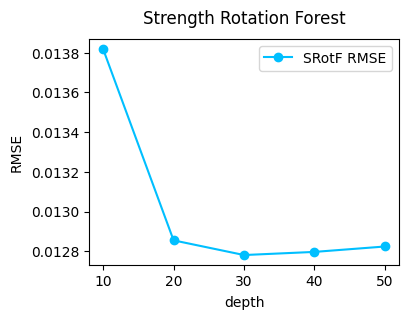

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

RMSE_set_rf_depth ,mape_set_rf_depth = [],[]
import matplotlib.pyplot as plt
cnt = 1
depths = [10,20,30,40,50]
for depth in depths:
    print(depth)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']
        
        SRF = Strength_Rotation_Forest(train_x,train_y,valid_x,max_depth=depth,size=0.7,n_trees=100, k = 3)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    RMSE_set_rf_depth.append(np.mean(RMSE_set_rf))

print(RMSE_set_rf_depth)
plot(rmse_set = RMSE_set_rf_depth , parameter_set = depths ,x_label = "depth" ,title= "Strength Rotation Forest", labels= "SRotF RMSE")

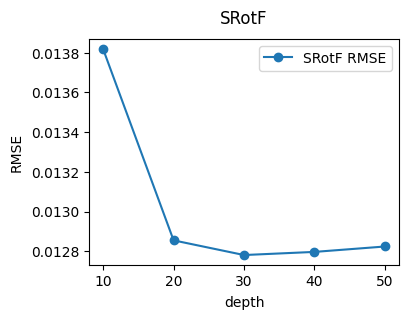

In [2]:
import matplotlib.pyplot as plt
depths = [10,20,30,40,50]
RMSE_set_rf_depth = [0.013818327102136856, 0.01285563419089326, 0.012781716337724697, 0.012797514872755988, 0.012824710992262123]
plot(rmse_set = RMSE_set_rf_depth , parameter_set = depths ,x_label = "depth" ,title= "SRotF", labels= "SRotF RMSE")

0.5
0.7
0.9
[0.013342462180635936, 0.01277352570318183, 0.012449982142792847]


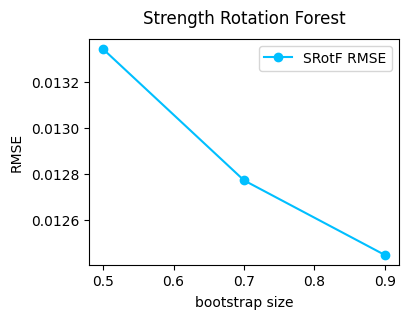

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

RMSE_set_rf_depth ,mape_set_rf_depth = [],[]
import matplotlib.pyplot as plt
cnt = 1
bootstrap_sizes = [0.5,0.7,0.9]

for bootstrap_size in bootstrap_sizes:
    print(bootstrap_size)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        SRF = Strength_Rotation_Forest(train_x , train_y, valid_x, max_depth = 20 , size = bootstrap_size , n_trees = 100, k = 3)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    RMSE_set_rf_depth.append(np.mean(RMSE_set_rf))

print(RMSE_set_rf_depth)
plot(rmse_set = RMSE_set_rf_depth , parameter_set = bootstrap_sizes ,x_label = "bootstrap size" ,title= "Strength Rotation Forest", labels= "SRotF RMSE")

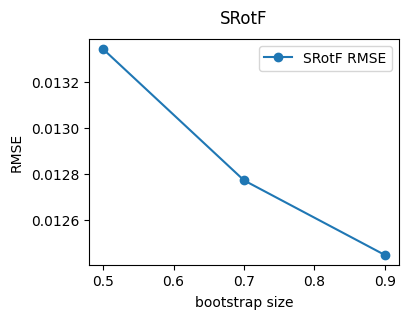

In [3]:
bootstrap_sizes = [0.5,0.7,0.9]
RMSE_set_rf_depth = [0.013342462180635936, 0.01277352570318183, 0.012449982142792847]
plot(rmse_set = RMSE_set_rf_depth , parameter_set = bootstrap_sizes ,x_label = "bootstrap size" ,title= "SRotF", labels= "SRotF RMSE")

300
500
700
900
[0.012322491971307376, 0.012298486511621208, 0.012328629780187969, 0.012291872323538419]


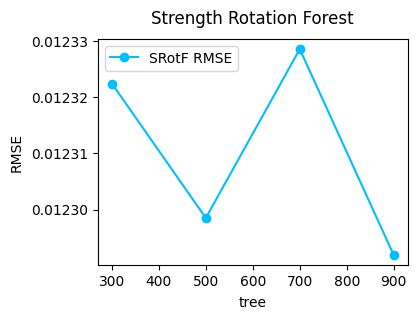

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

RMSE_set_rf_depth ,mape_set_rf_depth = [],[]
import matplotlib.pyplot as plt
cnt = 1

trees = [300,500,700,900]

for tree in trees:
    print(tree)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        SRF = Strength_Rotation_Forest(train_x , train_y, valid_x, max_depth = 30 , size = 0.9 , n_trees = tree, k = 3)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    RMSE_set_rf_depth.append(np.mean(RMSE_set_rf))

print(RMSE_set_rf_depth)
plot(rmse_set = RMSE_set_rf_depth , parameter_set = trees ,x_label = "tree" ,title= "Strength Rotation Forest", labels= "SRotF RMSE")

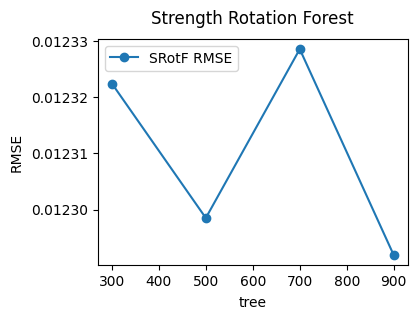

In [ ]:
RMSE_set_rf_depth = [0.012322491971307376, 0.012298486511621208, 0.012328629780187969, 0.012291872323538419]
trees = [300,500,700,900]
plot(rmse_set = RMSE_set_rf_depth , parameter_set = trees ,x_label = "tree" ,title= "Strength Rotation Forest", labels= "SRotF RMSE")

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cnt = 1
RMSE_set_rotf = []

for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
    print('fold',cnt)
    train_x = scaled_x.iloc[train_index,:]
    train_y = data.iloc[train_index,:]['stab']
    valid_x = scaled_x.iloc[valid_index,:]
    valid_y = data.iloc[valid_index,:]['stab']
  
    SRF = Strength_Rotation_Forest(train_x , train_y, valid_x, max_depth = 30, size = 0.9, n_trees = 900, k = 3)
    RMSE_set_rotf.append( np.asqrt( mean_squared_error(valid_y,SRF)))

    cnt+=1

print("srof",RMSE_set_rotf)
print("mean",np.mean(RMSE_set_rotf) )

fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
srof [0.01247070912851527, 0.01230166837510899, 0.012309614926834819, 0.011887058437732311, 0.011936242380422808, 0.011778953691370461, 0.011433052298641635, 0.012287924688088469, 0.011994871657213286, 0.012878514079182406]
mean 0.012127860966311046


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cnt = 1
RMSE_set_rotf = []

for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
    print('fold',cnt)
    train_x = scaled_x.iloc[train_index,:]
    train_y = data.iloc[train_index,:]['stab']
    valid_x = scaled_x.iloc[valid_index,:]
    valid_y = data.iloc[valid_index,:]['stab']
  
    SRF = Strength_Rotation_Forest(train_x , train_y, valid_x, max_depth = 30, size = 0.9, n_trees = 900, k = 3)
    RMSE_set_rotf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    cnt+=1

print("srof",RMSE_set_rotf)
print("mean",np.mean(RMSE_set_rotf) )

NameError: ignored